# TensorFlow

참고 : TensorFlow Machine Learning Cookbook

In [1]:
import tensorflow as tf
sess = tf.Session()

C:\Users\GIGABYTE\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np
import matplotlib.pyplot as plt

### 최근접 이웃 알고리즘
> 학습셋을 모델로 간주하고 새로운 점이 기존 학습셋의 점들과 얼마나 가까운지에 따라 예측한다. 
> 가장 가까운 학습셋 데이터 k개의 가중 평균값을 사용하는 것이 일반적이다. 
> 학습 데이터셋과 이에 해당하는 대상 값이 주어졌을 때 새로운 점에 대한 예측 값은 가장 가까운 학습 데이터셋을 이용해 구할 수 있다. 
> 구체적인 예측 방식은 회귀를 하는지, 분휴를 하는지에 따라 달라진다.

In [3]:
# 데이터 로드
import requests
housing_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
housing_header = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 
                  'PTRATIO', 'B', 'LSTAT', 'MEDV']
cols_used = ['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
num_features = len(cols_used)

housing_file = requests.get(housing_url)
housing_data = [[float(x) for x in y.split(' ') if len(x)>=1] 
                 for y in housing_file.text.split('\n') if len(y)>=1]

x_vals = np.array([[x for i, x in enumerate(y) if housing_header[i] in cols_used] for y in housing_data])
x_vals = (x_vals - x_vals.min(0)) / x_vals.ptp(0) # 정규화
y_vals = np.transpose([np.array([y[13] for y in housing_data])])


# 데이터 분할
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))

x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]


# k 값 및 일괄 작업 크기 선언
k = 4
batch_size = len(x_vals_test)


# 플레이스홀더 및 변수 선언
x_data_train = tf.placeholder(shape=[None,num_features], dtype=tf.float32)
x_data_test = tf.placeholder(shape=[None,num_features], dtype=tf.float32)
y_target_train = tf.placeholder(shape=[None,1], dtype=tf.float32)
y_target_test = tf.placeholder(shape=[None,1], dtype=tf.float32)


# L1 거리 함수 생성
distance = tf.reduce_sum(tf.abs(tf.subtract(x_data_train, tf.expand_dims(x_data_test,1))), axis=2)

# L2 거리 함수
# distance = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(s_data_train, tf.expand_dims(x_data_test,1))), reduction_indices=1))


# 예측 함수 선언
top_k_xvals, top_k_indices = tf.nn.top_k(tf.negative(distance), k=k)
x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals, 1), 1)
x_sums_repeated = tf.matmul(x_sums, tf.ones([1,k], tf.float32))
x_vals_weights = tf.expand_dims(tf.div(top_k_xvals, x_sums_repeated), 1)

top_k_yvals = tf.gather(y_target_train, top_k_indices)
prediction = tf.squeeze(tf.matmul(x_vals_weights, top_k_yvals), axis=[1])

mse = tf.div(tf.reduce_sum(tf.square(tf.subtract(prediction, y_target_test))), batch_size)


# 학습
num_loops = int(np.ceil(len(x_vals_test) / batch_size))

for i in range(num_loops):
    min_index = i * batch_size
    max_index = min((i+1) * batch_size, len(x_vals_train))
    
    x_batch = x_vals_test[min_index:max_index]
    y_batch = y_vals_test[min_index:max_index]
    
    predictions = sess.run(prediction, feed_dict={x_data_train:x_vals_train, 
                                                  x_data_test:x_batch,
                                                  y_target_train:y_vals_train,
                                                  y_target_test:y_batch})
    
    batch_mse = sess.run(mse, feed_dict={x_data_train:x_vals_train,
                                         x_data_test:x_batch,
                                         y_target_train:y_vals_train,
                                         y_target_test:y_batch})
    
    print('Batch #{} MSE : {}'.format(str(i+1), str(np.round(batch_mse,3))))

Batch #1 MSE : 10.665


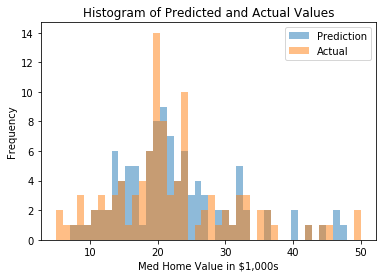

In [4]:
bins = np.linspace(5, 50, 45)

plt.hist(predictions, bins, alpha=0.5, label='Prediction')
plt.hist(y_batch, bins, alpha=0.5, label='Actual')
plt.title('Histogram of Predicted and Actual Values')
plt.xlabel('Med Home Value in $1,000s')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

> 어려운 일 한가지는 최적의 k값을 정하는 것이다. 
> 여러 가지 k 값에 대해 교차 검증을 진행해 보면 확인할 수 있다. <br>
> K-NN을 사용할 때 거리를 가중치에 반영했다.
> 거리 제곱의 역수를 가중치로 사용하는 방법도 있다.

### 혼합 거리 함수 계산

In [5]:
# 대각 가중 행렬 생성
weight_diagonal = x_vals.std(0)
weight_matrix = tf.cast(tf.diag(weight_diagonal), dtype=tf.float32)


# 거리 함수 선언
subtraction_term = tf.subtract(x_data_train, tf.expand_dims(x_data_test,1))
first_product = tf.matmul(subtraction_term, tf.tile(tf.expand_dims(weight_matrix, 0), [batch_size, 1, 1]))
second_product = tf.matmul(first_product, tf.transpose(subtraction_term, perm=[0, 2, 1]))
distance = tf.sqrt(tf.matrix_diag_part(second_product))


# 예측 함수 선언
top_k_xvals, top_k_indices = tf.nn.top_k(tf.negative(distance), k=k)
x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals, 1), 1)
x_sums_repeated = tf.matmul(x_sums, tf.ones([1,k], tf.float32))
x_vals_weights = tf.expand_dims(tf.div(top_k_xvals, x_sums_repeated), 1)

top_k_yvals = tf.gather(y_target_train, top_k_indices)
prediction = tf.squeeze(tf.matmul(x_vals_weights, top_k_yvals), axis=[1])

mse = tf.div(tf.reduce_sum(tf.square(tf.subtract(prediction, y_target_test))), batch_size)


# 학습
num_loops = int(np.ceil(len(x_vals_test) / batch_size))

for i in range(num_loops):
    min_index = i * batch_size
    max_index = min((i+1) * batch_size, len(x_vals_train))
    
    x_batch = x_vals_test[min_index:max_index]
    y_batch = y_vals_test[min_index:max_index]
    
    predictions = sess.run(prediction, feed_dict={x_data_train:x_vals_train, 
                                                  x_data_test:x_batch,
                                                  y_target_train:y_vals_train,
                                                  y_target_test:y_batch})
    
    batch_mse = sess.run(mse, feed_dict={x_data_train:x_vals_train,
                                         x_data_test:x_batch,
                                         y_target_train:y_vals_train,
                                         y_target_test:y_batch})
    
    print('Batch #{} MSE : {}'.format(str(i+1), str(np.round(batch_mse,3))))

Batch #1 MSE : 10.389


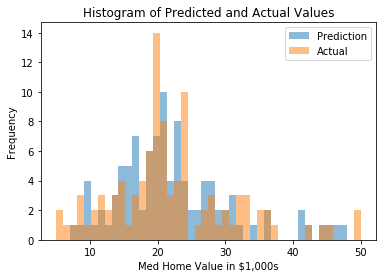

In [6]:
bins = np.linspace(5, 50, 45)

plt.hist(predictions, bins, alpha=0.5, label='Prediction')
plt.hist(y_batch, bins, alpha=0.5, label='Actual')
plt.title('Histogram of Predicted and Actual Values')
plt.xlabel('Med Home Value in $1,000s')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()